## Least Squared Linear Regression
## Coordinate Descent

Generate random data for the model:
$$y=\beta_{0}+\beta_{1}x_1+\dots+\beta_{n}x_n+e$$
where $e\sim N(0,\sigma^{2})$

In [1]:
%matplotlib notebook
import numpy as np
import time
import random

nsample = 1000
nvariables=10
X0 = np.ones([nsample,1]) #the firt column are ones for the beta_0
X1 = np.random.uniform(0.5,1.5,([nsample,nvariables]))
X = np.concatenate([X0, X1],axis=1)
beta=np.random.randint(-5,5,size=([nvariables+1,1]));beta
error=np.random.normal(0,1,(nsample,1))#normal random error
Y=np.dot(X,beta)+error
#print(beta)
#error=np.random.normal(0,1,(nsample,1))#normal random error
#Y=X*beta+error

We can plot with respect to any of the variables:

(<matplotlib.collections.PathCollection at 0x1b4fe5ece50>,
 Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y_p'))

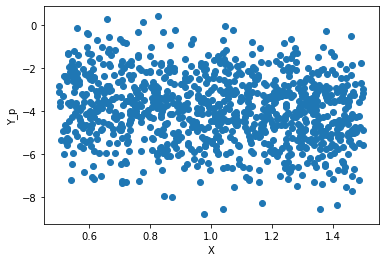

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
Y_p=np.array(Y)#convert to array for ploting
plt.scatter(X[:,1], Y_p),plt.xlabel('X'),plt.ylabel('Y_p')
#plt.scatter(X2, Y_p),plt.xlabel('X2'),plt.ylabel('Y_p')
#plt.scatter(X3, Y_p),plt.xlabel('X3'),plt.ylabel('Y_p')

Fit a linear relation between a set of variables ($X$) with respect to a response variable ($y$)

Model: $y = X\beta + u$

Classical estimation: least squares

  \begin{align*}
\text{minimize}\quad & ||y-X\beta||_2^2
\end{align*}

The exact solution is: $\beta_{ls}=(X^T X)^{-1}X^T y$

In [3]:
time_start = time.time()
beta_ls_exact=np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y)
time_elapsed = (time.time() - time_start)
print('time elapsed=',time_elapsed)
print(beta_ls_exact)

time elapsed= 0.0
[[-3.36658734]
 [-0.92082053]
 [ 2.02954826]
 [ 1.03316413]
 [-0.994283  ]
 [-1.01341232]
 [-1.96564423]
 [ 1.98869464]
 [ 0.08196519]
 [-0.92504425]
 [ 0.10963372]]


We now compute the least squares problem:

In [4]:
from scipy.optimize import minimize


def least_sq_reg(beta_ls, X, Y):
    beta_ls=np.matrix(beta_ls)
    #z=Y-np.dot(X,np.transpose(beta_ls))
    z=Y-X*np.transpose(beta_ls)
    return np.dot(np.transpose(z),z)

#beta_ls0 = np.matrix([0, 0, 0, 0])
beta_ls0 = np.zeros(nvariables+1)
time_start = time.time()
res = minimize(least_sq_reg, beta_ls0, args=(X, Y), method='Nelder-Mead', options={'disp': True,'xtol': 1e-10})
time_elapsed = (time.time() - time_start)
print('time elapsed=',time_elapsed)
print (res.x) 
print('error=',np.linalg.norm(np.transpose(beta_ls_exact)-res.x,ord=2)/np.linalg.norm(np.transpose(beta_ls_exact),ord=2))

time elapsed= 0.30555176734924316
[-2.39163796 -0.99629323  0.84793023  1.03129613 -0.95346047 -1.47533324
 -1.56328959  1.96171366 -1.38595073  0.64239916  0.38818622]
error= 0.5140523510613321


Or introduce ourselves the gradient and hessian information:

In [5]:
def least_sq_reg_der(beta_ls,X,Y):
    beta_ls=np.matrix(beta_ls)
    pp=-2*np.dot(np.transpose(Y-np.dot(X,np.transpose(beta_ls))),X)
    aa= np.squeeze(np.asarray(pp))
    return aa

def least_sq_reg_hess(beta_ls,X,Y):
    ss=2*np.dot(np.transpose(X),X)
    return ss



time_start = time.time()
#run your code
                   
res = minimize(least_sq_reg, beta_ls0, args=(X, Y), method='Newton-CG', jac=least_sq_reg_der, hess=least_sq_reg_hess, options={'disp': True})
time_elapsed = (time.time() - time_start) 
print('time elapsed=',time_elapsed)
print(res.x)
np.linalg.inv(least_sq_reg_hess(res.x,X,Y))
print('error=',np.linalg.norm(np.transpose(beta_ls_exact)-res.x,ord=2)/np.linalg.norm(np.transpose(beta_ls_exact),ord=2))
   

Optimization terminated successfully.
         Current function value: 992.181701
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7
time elapsed= 0.0
[-3.3665863  -0.92082064  2.02954819  1.033164   -0.99428314 -1.01341242
 -1.96564434  1.98869454  0.0819651  -0.92504434  0.10963361]
error= 2.06694432080338e-07


### Coordinate descent

Start with $x_0$, then choose index $i_k\in\{1,2,\dots,b\}$ and 
\begin{equation*}
x_{k+1}=x_k-\alpha_k\nabla_{i_k}f(x_k)e_{i_k},
\end{equation*}
where $\alpha_k$ is the step size, $e_i$ is the $i$-th canonici vector and $\nabla_if(x)$ the $i$-coordinate of the gradient vector.

We will select $i_k$ ramdonly.

In [6]:
#Descenso por coordenadas
(a, b) = X.shape

def least_sq_reg_der_coord(beta_ls,index,X,Y):
    pp=np.array(-2*np.dot((Y-np.dot(X,beta_ls)).T,X[:,index]))
    aa=np.zeros([b,1])
    aa[index]=pp
    return aa.T


niter = 100000
epsilon = 1e-9
i = 0
alpha = 1e-5
OF_iter = np.zeros(niter)
tol_iter = np.zeros(niter)
error_coord_iter = []
tol = 10
beta_coord = np.zeros([b,1])

time_start = time.time()

while (i < niter) and (tol > epsilon):
    k = np.random.randint(b)
    gradk = least_sq_reg_der_coord(beta_coord,k,X,Y).T
    beta_coord = beta_coord - alpha*gradk
    tol = np.linalg.norm(gradk, ord = 2)
    OF_iter[i]  = least_sq_reg(beta_coord.T, X, Y)
    tol_iter[i] = tol
    error_coord_iter.append(np.linalg.norm(np.transpose(beta_ls_exact) - beta_coord.T, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2))
    i +=1
    
    
time_elapsed = (time.time() - time_start)
print('time elapsed =',time_elapsed)
print('betas coord =',beta_coord)
print('betas exact =', beta_ls_exact.T)
print('number iterations =',i)
print('tolerance=',tol) 
print('error', np.linalg.norm(np.transpose(beta_ls_exact) - beta_coord.T, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2)) 

time elapsed = 30.063782930374146
betas coord = [[-2.57080885]
 [-0.99958278]
 [ 1.94833615]
 [ 0.95856798]
 [-1.0907289 ]
 [-1.08778837]
 [-2.04279661]
 [ 1.9122116 ]
 [ 0.00470273]
 [-1.00596196]
 [ 0.039872  ]]
betas exact = [[-3.36658734 -0.92082053  2.02954826  1.03316413 -0.994283   -1.01341232
  -1.96564423  1.98869464  0.08196519 -0.92504425  0.10963372]]
number iterations = 100000
tolerance= 1.4690988153868076
error 0.15740508224021532


Text(0, 0.5, 'error')

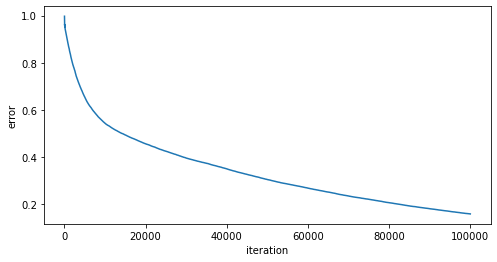

In [7]:
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_coord_iter)
plt.xlabel('iteration')
plt.ylabel('error')

Text(0, 0.5, 'error')

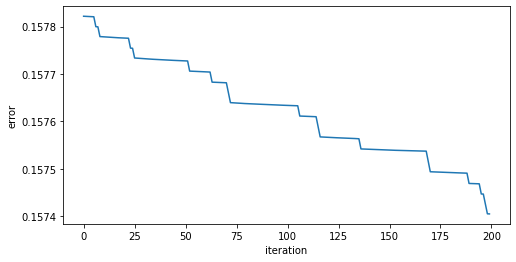

In [8]:
n_last=200
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_coord_iter[-n_last:])
plt.xlabel('iteration')
plt.ylabel('error')

### Comparison with SG

In [9]:
(a, b) = X.shape
niter = 100000
epsilon = 1e-4
i = 0
alpha = 1e-5 #need to be reescaled, the OF is nsample times higher
OF_iter = np.zeros(niter)
tol_iter = np.zeros(niter)
error_grad_iter = np.zeros(niter)
tol = 10
beta_grad = np.zeros(b)


time_start = time.time()

while (i < niter) and (tol > epsilon): 
    grad = least_sq_reg_der(beta_grad.T, X, Y)
    beta_grad=beta_grad-alpha*grad
    tol = np.linalg.norm(grad, ord = 2)
    OF_iter[i]  = least_sq_reg(beta_grad, X, Y)
    tol_iter[i] = tol
    error_grad_iter[i] = np.linalg.norm(np.transpose(beta_ls_exact) - beta_grad, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2)
    i +=1     
time_elapsed = (time.time() - time_start)
print('time elapsed =',time_elapsed)
print('betas grad =',beta_grad)
print('betas exact =', beta_ls_exact.T)
print('number iterations =',i)
print('tolerance=',tol) 
print('final error =', np.linalg.norm(np.transpose(beta_ls_exact) - beta_grad, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2)) 

time elapsed = 33.09663963317871
betas grad = [-3.36658081 -0.92082118  2.02954759  1.03316352 -0.99428379 -1.01341293
 -1.96564487  1.98869402  0.08196456 -0.92504491  0.10963315]
betas exact = [[-3.36658734 -0.92082053  2.02954826  1.03316413 -0.994283   -1.01341232
  -1.96564423  1.98869464  0.08196519 -0.92504425  0.10963372]]
number iterations = 89201
tolerance= 9.999898417173299e-05
final error = 1.2913122982398867e-06


<ipython-input-10-410347dbf0eb>:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(error_grad_iter))


Text(0, 0.5, 'log(error)')

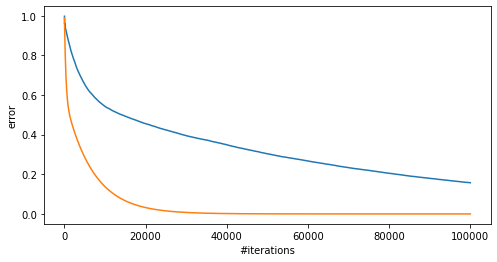

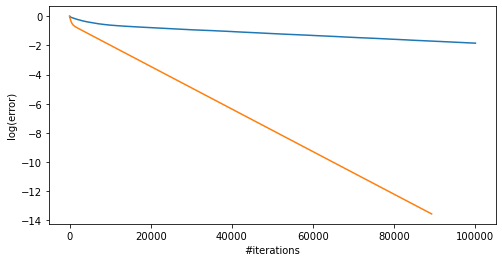

In [10]:
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_coord_iter)
plt.plot(error_grad_iter)
plt.xlabel('#iterations')
plt.ylabel('error')

plt.fig = plt.figure(figsize=(8,4))
plt.plot(np.log(error_coord_iter))
plt.plot(np.log(error_grad_iter))
plt.xlabel('#iterations')
plt.ylabel('log(error)')